In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# DAC function
def dac_12bit(binary_code, v_ref=5.0):
    """Convert 12-bit binary code to analog voltage"""
    return (int(binary_code, 2) / (2**12)) * v_ref

In [3]:
# Sample and Hold function
def sample_and_hold(analog_signal, sample_time, t):
    """Sample input at specified times"""
    return analog_signal[np.searchsorted(t, sample_time)]

In [4]:
# Comparator function
def comparator(v_plus, v_minus):
    """1-bit comparator: returns 1 if v_plus > v_minus, else 0"""
    return 1 if v_plus > v_minus else 0


In [5]:
# SAR Control Logic
def sar_control_logic(comparator_output, current_bit):
    """Determine next DAC test value and update SAR register"""
    return current_bit - 1, 1 if comparator_output else 0


In [6]:
# SAR Register function
def sar_register(bit_position, bit_value, current_code):
    """Update SAR register with new bit value"""
    mask = 1 << bit_position
    return (current_code & ~mask) | ((bit_value << bit_position) & mask)


In [7]:
# Main simulation parameters
fs = 10e6  # Sampling frequency (10 MS/s)
f_signal = 1e6  # Input signal frequency
v_ref = 5.0
n_bits = 12
sim_time = 200e-9  # Simulate 200 ns to show 2 conversion cycles

# Generate time base and input signal
t = np.arange(0, sim_time, 1/(100*fs))  # High resolution time base
analog_input = 2.5 + 2.5*np.cos(2*np.pi*f_signal*t)  # 0-5V cosine wave

# Sample timing
sample_times = np.arange(0, sim_time, 1/fs)
sampled_voltages = sample_and_hold(analog_input, sample_times, t)


In [8]:
# SAR Conversion process
dac_outputs = []
comparator_outputs = []
sar_codes = []

# SAR Conversion process
for sample in sampled_voltages:
    sar_code = 0  # Start with all bits cleared
    current_bit = n_bits - 1  # Start testing from the MSB
    
    dac_steps = []  # Store DAC outputs during this conversion cycle
    comp_decisions = []  # Store comparator decisions
    
    # 12-bit conversion cycle
    for _ in range(n_bits):
        # Set the current bit to 1 temporarily
        sar_code |= (1 << current_bit)
        
        # Generate DAC output based on current SAR code
        dac_voltage = dac_12bit(bin(sar_code)[2:].zfill(n_bits), v_ref)
        
        # Comparator output: Check if VIN > VDAC
        comp_out = comparator(sample, dac_voltage)
        
        if comp_out == 0:
            # If VIN <= VDAC, clear the current bit back to 0
            sar_code &= ~(1 << current_bit)
        
        # Store results for visualization
        dac_steps.append(dac_voltage)
        comp_decisions.append(comp_out)
        
        # Move to the next lower bit (LSB direction)
        current_bit -= 1
    
    # Store results for this sample
    dac_outputs.extend(dac_steps)
    comparator_outputs.extend(comp_decisions)
    sar_codes.append(sar_code)

# Convert final codes to binary strings
binary_output = [bin(code)[2:].zfill(n_bits) for code in sar_codes]


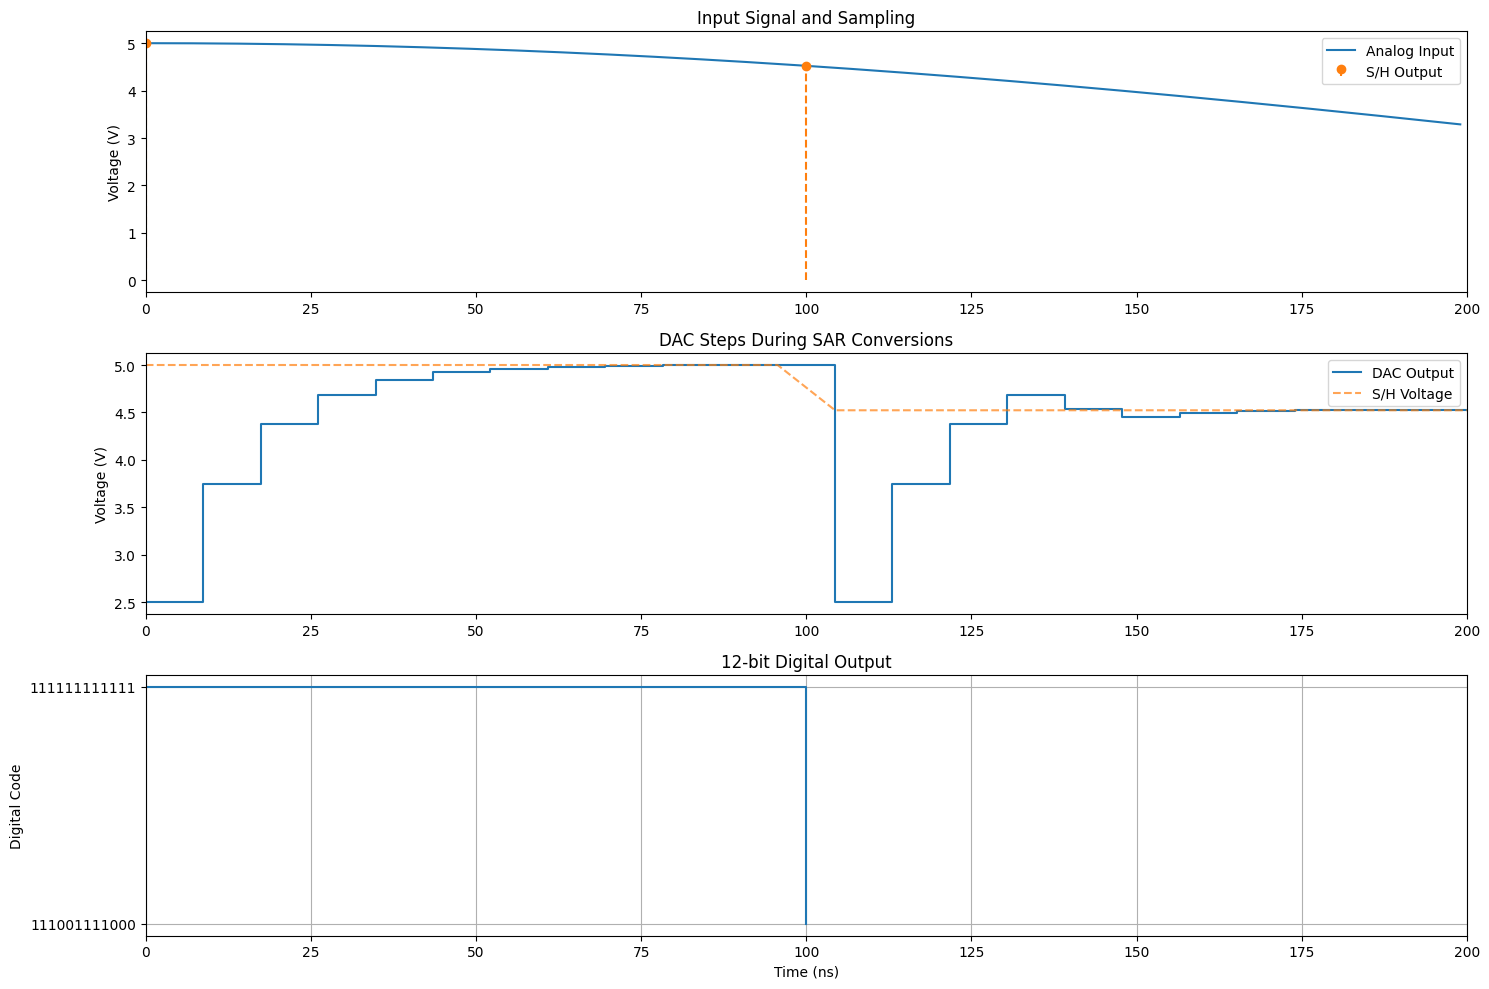

In [20]:
# Plotting results

plt.figure(figsize=(15, 10))

# Analog input and sampled values
plt.subplot(3, 1, 1)
plt.plot(t*1e9, analog_input, label='Analog Input')
plt.stem(sample_times*1e9, sampled_voltages, linefmt='C1--', markerfmt='C1o', basefmt=' ', label='S/H Output')
plt.ylabel('Voltage (V)')
plt.title('Input Signal and Sampling')
plt.xlim(0, sim_time*1e9)
plt.legend()

# DAC Steps during conversion
plt.subplot(3, 1, 2)
conversion_times = np.linspace(0, sim_time, len(dac_outputs))
plt.step(conversion_times*1e9, dac_outputs, where='post', label='DAC Output')
plt.plot(conversion_times*1e9,
         np.repeat(sampled_voltages, n_bits), '--', alpha=0.7,
         label='S/H Voltage')
plt.ylabel('Voltage (V)')
plt.title('DAC Steps During SAR Conversions')
plt.xlim(0, sim_time*1e9)
plt.legend()

# Binary output
plt.subplot(3, 1, 3)
plt.step(sample_times*1e9, sar_codes, where='post', label='Digital Output')
plt.ylabel('Digital Code')
plt.xlabel('Time (ns)')
plt.title('12-bit Digital Output')
plt.xlim(0, sim_time*1e9)
plt.yticks(sar_codes[:10], binary_output[:10]) # Display first few binary outputs for clarity.
plt.grid(True)

plt.tight_layout()
plt.show()
